In [1]:
# Import necessary libraries and modules for data generation and model training
import matplotlib.pyplot as plt

import shapes1d_dataset_generator as ShapeGen

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
train_on_gpu = torch.cuda.is_available()
display(train_on_gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True

# Shapes1dDataset

The dataset consists of sequences where each shape (triangle or rectangle) has a specific width, height, and position. The input sequences represent the original shapes, while the target sequences modify the heights to reflect the average for each shape type.

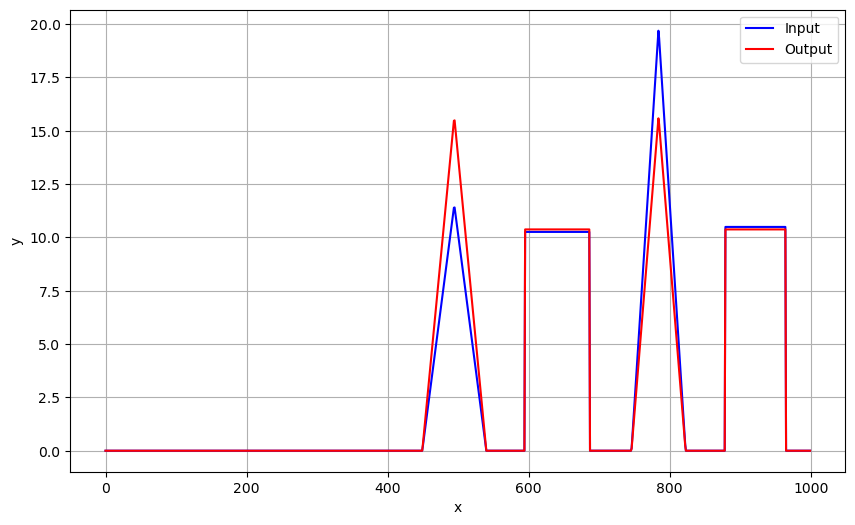

In [3]:
# Initialize and prepare the Shapes1d dataset, generating sequences of shapes (input and target)
gen = ShapeGen.GeneratorShapes(10)
x0, y0, x, y, = gen.generate()
ShapeGen.plot_shapes(y0,y)

The input y0 is a sequence of shapes, while the target y is a sequence of shapes with modified heights. The goal is to train a model to predict the target sequence y.

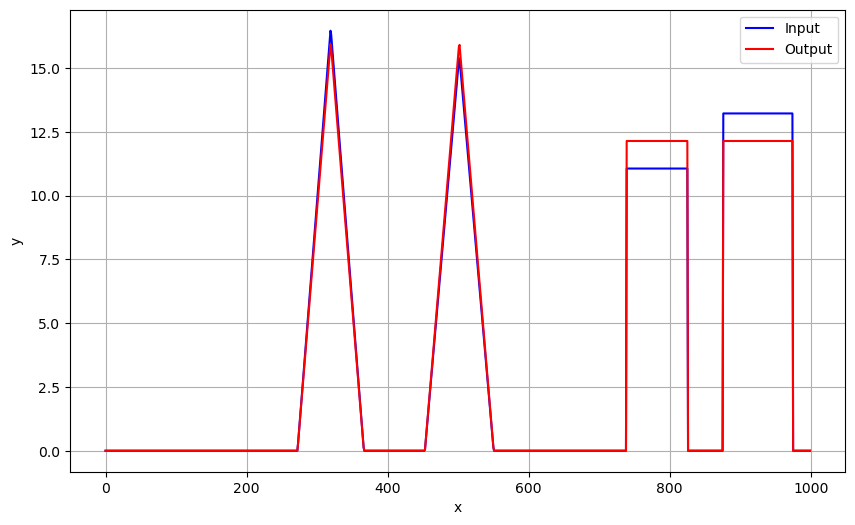

In [4]:
# Initialize and prepare the Shapes1d dataset, generating sequences of shapes (input and target)
training_data = ShapeGen.Shapes1dDataset(10000,10)
training_loader = DataLoader(training_data, batch_size=32, shuffle=True)

_x, _y = next(iter(training_loader))
ShapeGen.plot_shapes(_x[0],_y[0])

# Conv1DNet and Conv1DNetWithAttention
We define two models: `Conv1DNet` and `Conv1DNetWithAttention`. The `Conv1DNet` model consists of four convolutional layers, while the `Conv1DNetWithAttention` model includes an additional multi-head attention layer.

In [5]:
class Conv1DNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=1,  out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding=2)
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=1, kernel_size=5, padding=2)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)

        return x
    
class Conv1DNetWithAttention(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=1,  out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.attention = nn.MultiheadAttention(embed_dim=128, num_heads=1) 
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding=2)
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=1, kernel_size=5, padding=2)

        self.relu = nn.ReLU()

    def forward(self, x, return_attention=False):

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        # Permute: (B, 64, seq_len) to (seq_len, B, 64)
        x_perm = x.permute(2, 0, 1)

        attn_out, attn_weights = self.attention(x_perm, x_perm, x_perm)

        # back to (B, 64, seq_len)
        x = attn_out.permute(1, 2, 0)

        x = self.relu(self.conv3(x))
        x = self.conv4(x)

        if return_attention:
            return x, attn_weights
        else:
            return x

In [6]:
# Define the loss function and optimizer for model training
def train_model(model, dataloader, num_epochs=10, lr=1e-3, device='cuda'):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for i, (x_batch, y_batch) in enumerate(dataloader):
            x_batch = x_batch.unsqueeze(1)
            y_batch = y_batch.unsqueeze(1)
            x_batch = x_batch.to(device)  # shape: [B, 1, seq_len]
            y_batch = y_batch.to(device)  # shape: [B, 1, seq_len]

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(dataloader)
        losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

    return losses


## Training without Attention

In [7]:
# Define the loss function and optimizer for model training
# Modell without Attention
model_no_attn = Conv1DNet()
print("Training Modell without Attention ...")
loss_no_attn = train_model(model_no_attn, training_loader, num_epochs=250, lr=1e-3)

Training Modell without Attention ...
Epoch [1/250], Loss: 1.612364
Epoch [2/250], Loss: 1.063216
Epoch [3/250], Loss: 1.039149
Epoch [4/250], Loss: 1.015531
Epoch [5/250], Loss: 1.023990
Epoch [6/250], Loss: 1.022614
Epoch [7/250], Loss: 1.015104
Epoch [8/250], Loss: 0.991251
Epoch [9/250], Loss: 1.011758
Epoch [10/250], Loss: 1.012265
Epoch [11/250], Loss: 1.002703
Epoch [12/250], Loss: 1.004643
Epoch [13/250], Loss: 0.997861
Epoch [14/250], Loss: 0.984616
Epoch [15/250], Loss: 1.003339
Epoch [16/250], Loss: 0.985894
Epoch [17/250], Loss: 0.986872
Epoch [18/250], Loss: 0.986754
Epoch [19/250], Loss: 0.984242
Epoch [20/250], Loss: 0.985965
Epoch [21/250], Loss: 0.980519
Epoch [22/250], Loss: 0.980892
Epoch [23/250], Loss: 0.981201
Epoch [24/250], Loss: 0.978333
Epoch [25/250], Loss: 0.979083
Epoch [26/250], Loss: 0.981653
Epoch [27/250], Loss: 0.975491
Epoch [28/250], Loss: 0.972122
Epoch [29/250], Loss: 0.986970
Epoch [30/250], Loss: 0.974966
Epoch [31/250], Loss: 0.973104
Epoch [32/

## Training with Attention

In [8]:
# Define the loss function and optimizer for model training
# Modell with Attention
model_with_attn = Conv1DNetWithAttention()
print("\nTraining Modell with Attention ...")
loss_with_attn = train_model(model_with_attn, training_loader, num_epochs=250, lr=1e-3)


Training Modell with Attention ...
Epoch [1/250], Loss: 2.337470
Epoch [2/250], Loss: 0.454096
Epoch [3/250], Loss: 0.444295
Epoch [4/250], Loss: 0.364984
Epoch [5/250], Loss: 0.209169
Epoch [6/250], Loss: 0.131403
Epoch [7/250], Loss: 0.121673
Epoch [8/250], Loss: 0.190365
Epoch [9/250], Loss: 0.116621
Epoch [10/250], Loss: 0.104826
Epoch [11/250], Loss: 0.111087
Epoch [12/250], Loss: 0.106879
Epoch [13/250], Loss: 0.101400
Epoch [14/250], Loss: 0.098980
Epoch [15/250], Loss: 0.096268
Epoch [16/250], Loss: 0.094145
Epoch [17/250], Loss: 0.096273
Epoch [18/250], Loss: 0.097449
Epoch [19/250], Loss: 0.095714
Epoch [20/250], Loss: 0.093964
Epoch [21/250], Loss: 0.091065
Epoch [22/250], Loss: 0.091135
Epoch [23/250], Loss: 0.087566
Epoch [24/250], Loss: 0.090045
Epoch [25/250], Loss: 0.090929
Epoch [26/250], Loss: 0.085064
Epoch [27/250], Loss: 0.090688
Epoch [28/250], Loss: 0.084089
Epoch [29/250], Loss: 0.088287
Epoch [30/250], Loss: 0.087271
Epoch [31/250], Loss: 0.085646
Epoch [32/25

## Loss Comparison

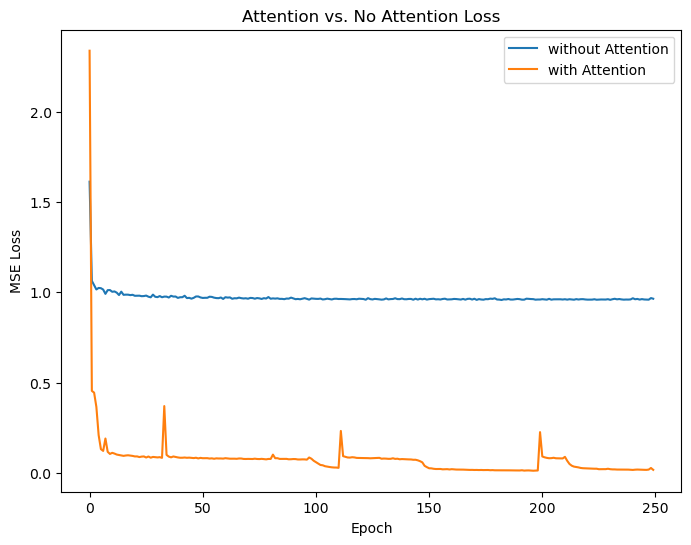

In [9]:
# Plot the loss curves for the models with and without attention
plt.figure(figsize=(8, 6))
plt.plot(loss_no_attn, label='without Attention')
plt.plot(loss_with_attn, label='with Attention')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Attention vs. No Attention Loss") 
plt.show()

The model with attention converges to a much lower loss compared to the model without attention. This suggests that the attention mechanism helps in accurately learning the relationships between the shapes and their corresponding heights.TThe attention mechanism is effectively focusing on relevant parts of the input sequence to compute the mean heights of shapes by type. 

In [10]:
# Train the model to predict the target sequence based on the input sequence
# predict from Trainingsset
x_sample, y_sample = training_data[0]
x_sample = x_sample.unsqueeze(0)
x_sample = x_sample.unsqueeze(1)
x_sample = x_sample.to(device)

y_pred_no_attn = model_no_attn(x_sample).detach().squeeze().cpu()
y_pred_attn = model_with_attn(x_sample).detach().squeeze().cpu()

## Input data vs. Ground Truth

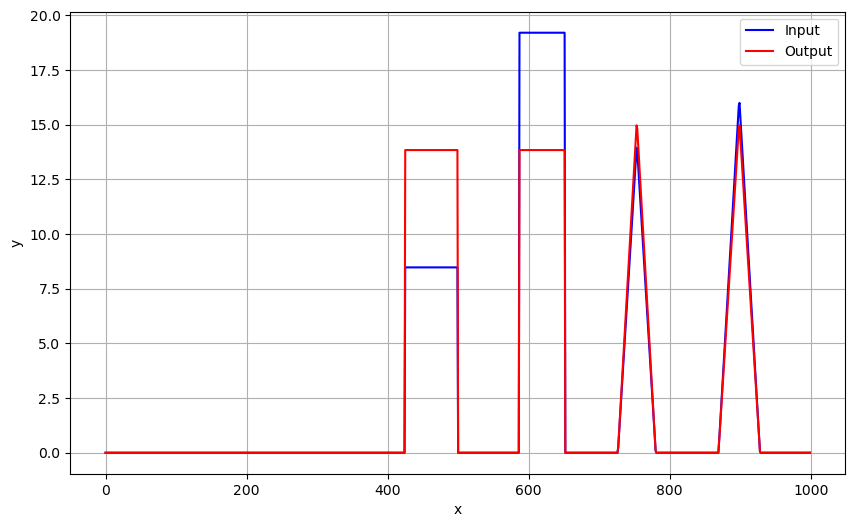

In [11]:
# Visualize the input and target sequences to understand the data structure
# Plot
ShapeGen.plot_shapes(x_sample[0,0].cpu(), y_sample)

## Prediction without Attention vs Ground Truth

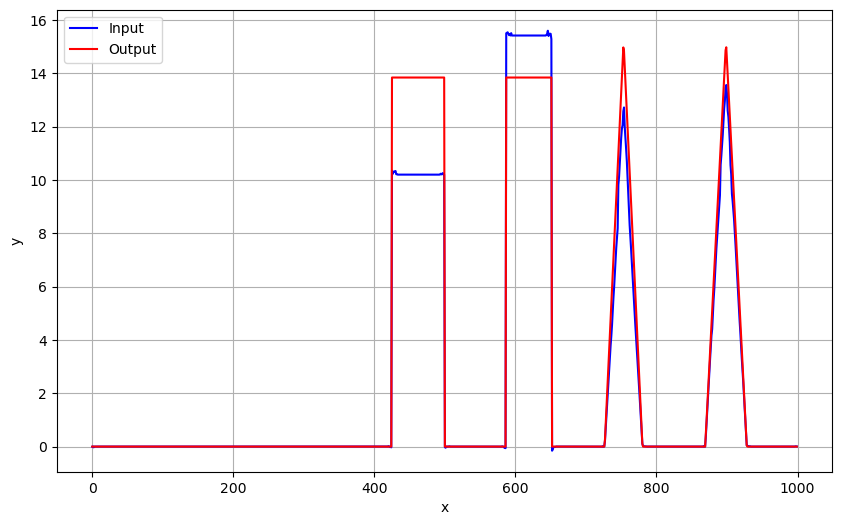

In [12]:
# Visualize the input and target sequences to understand the data structure
ShapeGen.plot_shapes(y_pred_no_attn.cpu(), y_sample)

The model without attention predicts the position of the shapes but fails to accurately predict the heights. The attention is obvousliy needed to learn the relationships between the shapes and their heights.

## Prediction with Attention vs Ground Truth

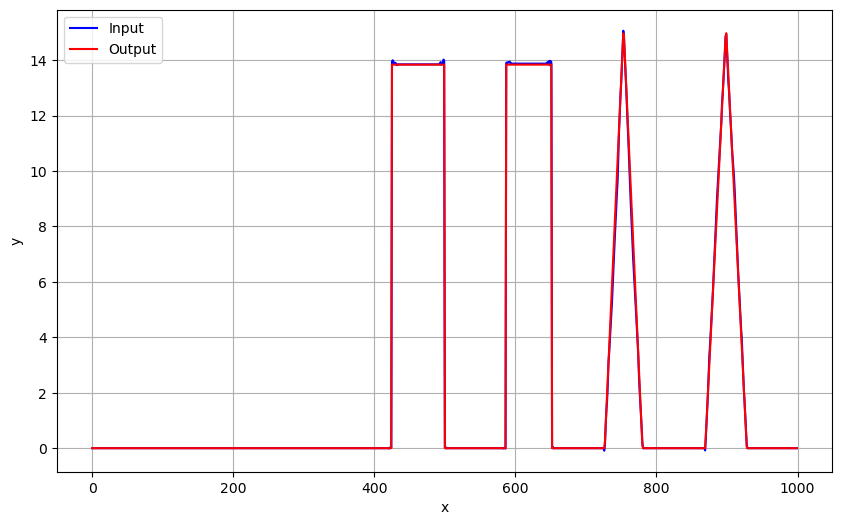

In [13]:
# Visualize the input and target sequences to understand the data structure
ShapeGen.plot_shapes(y_pred_attn.cpu(), y_sample)

the attention-based model provides highly accurate predictions, as evidenced by the close alignment between the predicted values and the ground truth. The strong correspondence in both peak regions and flat segments highlights the model's ability to capture complex data dynamics, though slight improvements could be made to further refine the transitions. This proofs the attention mechanism's effectiveness in learning the relationships between the shapes and their heights.

In [14]:
# Train the model to predict the target sequence based on the input sequence
# Angenommen wir haben schon ein trainiertes Modell:
model_with_attn = Conv1DNetWithAttention()
# ... (Training-Code) ...
model_with_attn.eval()

# Beispiel: Ein einziges Sample aus dem Dataset
x_sample, y_sample = training_data[0]               # x_sample: [1, seq_len], y_sample: [1, seq_len]
x_sample = x_sample.unsqueeze(0).unsqueeze(1)              # -> [B=1, 1, seq_len]
with torch.no_grad():
    pred, attn_weights = model_with_attn(x_sample, return_attention=True)

print("pred shape:", pred.shape)              # -> [1, 1, seq_len]
print("attn_weights shape:", attn_weights.shape)
# Mit average_attn_weights=False -> [B, num_heads, seq_len, seq_len]
# => [1, 4, seq_len, seq_len] bei num_heads=4


pred shape: torch.Size([1, 1, 1000])
attn_weights shape: torch.Size([1, 1000, 1000])


In [15]:
def plot_attention_weights(attn_weights):
    """
    attn_weights: Tensor der Form [B, num_heads, seq_len, seq_len]
    Wenn num_heads fehlt (z. B. bei num_heads=1), fügen wir sie hinzu.
    """
    # Add num_heads dimension if missing
    if attn_weights.dim() == 3:  # [B, seq_len, seq_len]
        attn_weights = attn_weights.unsqueeze(1)  # -> [B, 1, seq_len, seq_len]

    # Assume B=1 for visualization:
    attn_weights = attn_weights[0]  # => [num_heads, seq_len, seq_len]
    num_heads, seq_len, _ = attn_weights.shape

    fig, axes = plt.subplots(1, num_heads, figsize=(4 * num_heads, 4))
    if num_heads == 1:
        axes = [axes]  # Ensure consistency in handling single head
    
    for h in range(num_heads):
        # Extract the attention matrix for this head
        attn = attn_weights[h].detach().cpu().numpy()

        # Plot as a heatmap
        ax = axes[h]
        im = ax.imshow(attn, cmap="viridis", aspect='auto')
        ax.set_title(f"Head {h}")
        ax.set_xlabel("Key/Value Position")
        ax.set_ylabel("Query Position")
        fig.colorbar(im, ax=ax)

    fig.suptitle("Attention Weights Heatmap pro Head", fontsize=16)
    plt.tight_layout()
    plt.show()


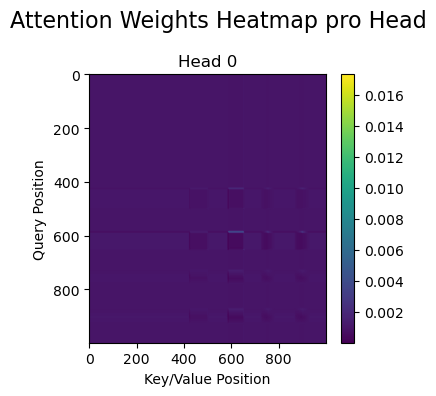

In [16]:
plot_attention_weights(attn_weights)

The heatmap indicates that this attention head focuses on localized and periodic patterns within the sequence, particularly around regions of higher relevance (e.g., positions 400, 600, and 800) as seen in the plot `Prediction with Attention vs Ground Truth`.